In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # calculate distance matrix
from scipy.linalg import lu # calculate LU decomposition
from scipy.optimize import minimize # minimization of scalar function
from itertools import combinations

# 1. Generate $Y$

## 1-1. Distance matrix

 $ d_{ij} = ||X_i - X_j||$

In [2]:
# function that makes coordincates of data points
def make_coords(N_points, xmu, xsd, ymu, ysd):
  x_coords = np.random.normal(xmu, xsd, size=N_points)
  y_coords = np.random.normal(ymu, ysd, size=N_points)
  coords = np.column_stack((x_coords, y_coords))

  return coords

In [3]:
# function that calculates distances between coordinates
def distances(coords):
  distances = cdist(coords, coords, metric='Euclidean')

  return distances

In [4]:
np.random.seed(24)

In [5]:
# set parameters
p = 1000 # dimensionaltiy

In [6]:
# get coordinates
coord = [0, 1, 0, 1] # xmu, xsd, ymu, ysd
X = make_coords(p, *coord)

In [7]:
# get distance matrix
d = distances(X)
d.shape

(1000, 1000)

## 1-2. Covariance Matrix $\Sigma$
$ \Sigma = Cov(Y_i, Y_j|X) = \theta_1 \exp(-\frac{1}{\theta_2} d_{ij}) $

In [8]:
# function that makes covariance matrix Sigma
def Sigma(param, dis):
  theta1, theta2 = param[0], param[1]
  cov = theta1*np.exp((-1/theta2)*dis) # distance matrix is a square matrix
  return cov

In [9]:
# set parameter for Sigma
paramTrue = [1, 1/2]
SigmaTrue = Sigma(paramTrue, d)

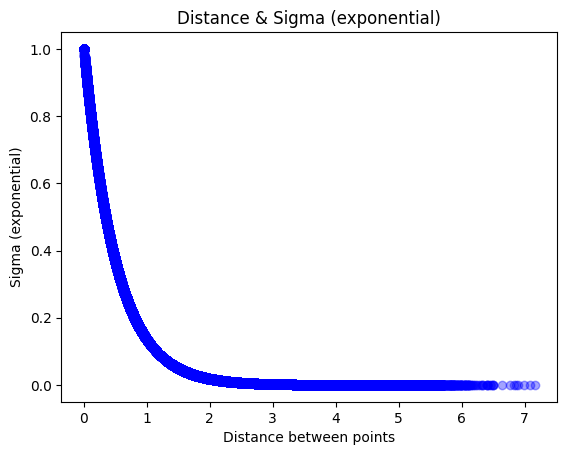

In [10]:
# plotting
d_plot = d.reshape((p*p,))
Sigma_plot = SigmaTrue.reshape((p*p,))
data = pd.DataFrame({'Distances': d_plot, 'Sigma(exp)': Sigma_plot})

plt.scatter(data['Distances'], data['Sigma(exp)'], c='blue', alpha=0.2)
plt.ylabel('Sigma (exponential)')
plt.xlabel('Distance between points')
plt.title('Distance & Sigma (exponential)')
plt.show()

# 1-3. Generate data $Y$
* $ Y = \Sigma^{1/2} \cdot U $
  * $\Sigma$ is positive semi definite
  * $U \sim N(0, I_p)$

* Dataframe of $Y$ ; N $\times$ p
  * Size: N = 1000
  * Dimensionality: p = 1000







In [11]:
# get sigmahalf
## cf. check if SigmaTrue is positive definite
pd = np.linalg.eig(SigmaTrue)[0].min() > 0
if pd:
    SigmaHalf = np.linalg.cholesky(SigmaTrue)
    print('Covariance matrix is positive definite')
else:
    print('Covariance matrix is not positive definite')

Covariance matrix is positive definite


In [12]:
import pandas as pd

In [13]:
N = 1000 # size

results = []

for i in range(N):
  U = np.random.normal(0, 1, p).reshape(p, 1)
  results.append(np.dot(SigmaHalf, U))

col_names = ['y{}'.format(i+1) for i in range(p)]
y_df = pd.DataFrame(np.reshape(results, (N, p)), columns=col_names)

# 2. Calculated Covariance


In [14]:
cov = np.cov(y_df.T) # cf. np.cov; each row represents variavble, each column a single observation
cov.shape

(1000, 1000)

In [15]:
cov

array([[ 1.0671614 ,  0.01953271, -0.0237897 , ...,  0.17660543,
         0.047687  ,  0.31095745],
       [ 0.01953271,  1.09095973, -0.06709482, ...,  0.04671776,
         0.00390517,  0.01471955],
       [-0.0237897 , -0.06709482,  0.97320535, ...,  0.03732469,
         0.01538712,  0.02038718],
       ...,
       [ 0.17660543,  0.04671776,  0.03732469, ...,  1.03767641,
         0.06689033,  0.10544058],
       [ 0.047687  ,  0.00390517,  0.01538712, ...,  0.06689033,
         0.98563101,  0.01429281],
       [ 0.31095745,  0.01471955,  0.02038718, ...,  0.10544058,
         0.01429281,  1.04108474]])

In [16]:
# make matrix into array
d_plot = d.reshape((p*p,)) 
cov_plot = cov.reshape((p*p, ))

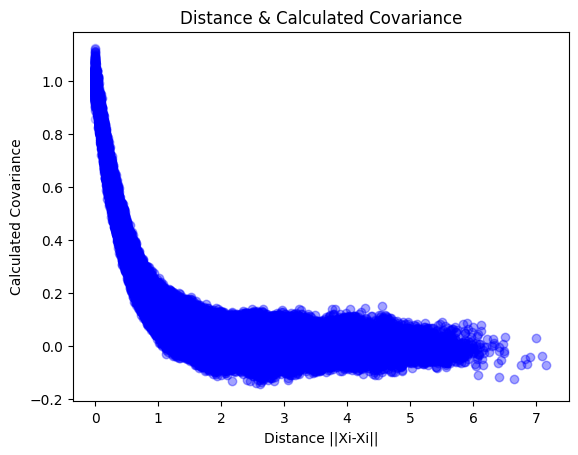

In [17]:
# plotting
plt.scatter(d_plot, cov_plot, c='blue', alpha=0.2)
plt.ylabel('Calculated Covariance')
plt.xlabel('Distance ||Xi-Xi||')
plt.title('Distance & Calculated Covariance')
plt.show()

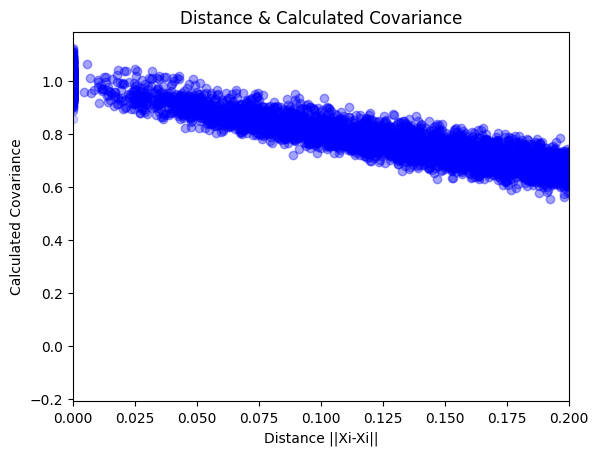

In [18]:
# plotting
plt.scatter(d_plot, cov_plot, c='blue', alpha=0.2)
plt.ylabel('Calculated Covariance')
plt.xlabel('Distance ||Xi-Xi||')
plt.title('Distance & Calculated Covariance')
plt.xlim(0, 0.2)
plt.show()

## 2*. Remove i = j pairs

In [19]:
# remove if distance = 0
cal_cov_df = pd.DataFrame({'Distance': d_plot, 'Calculated Covariance': cov_plot})
mask = (cal_cov_df['Distance'] != 0)

filtered_df = cal_cov_df[mask]

d_plot = filtered_df['Distance']
cov_plot = filtered_df['Calculated Covariance']


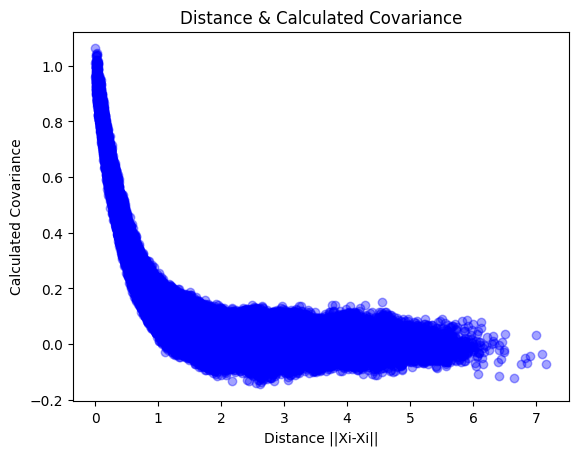

In [20]:
# plotting
plt.scatter(d_plot, cov_plot, c='blue', alpha=0.2)
plt.ylabel('Calculated Covariance')
plt.xlabel('Distance ||Xi-Xi||')
plt.title('Distance & Calculated Covariance')
plt.show()

# 3. Regression
$ Cov(y_i, y_j|X) = E[y_i*y_j|X] = ?$

where $ X = ||xi-xj||$

In [27]:
from scipy.stats import linregress
from scipy.optimize import curve_fit

## 3-1. $ Cov(yi, yj|X) $
* Assume exponential covariance model.
* The model follows $ Cov(yi, yj|X) = \theta_1 exp(-\theta_2 X)$

In [22]:
# define the exponential function
def exp_func(dis, theta1, theta2):
    return theta1*np.exp(-theta2*dis)

In [23]:
# perform exponential regression
params, param_cov = curve_fit(exp_func, d_plot, cov_plot)

cov_theta1, cov_theta2 = params

# generate fitted curve
x_fit1 = np.linspace(min(d_plot), max(d_plot), 100)
y_fit1 = exp_func(x_fit1, cov_theta1, cov_theta2)

fit1 = 'Fitted curve: {} * exp(-{} * X)'.format(round(cov_theta1,4), round(cov_theta2,4))
print(fit1)

Fitted curve: 0.9881 * exp(-2.0101 * X)


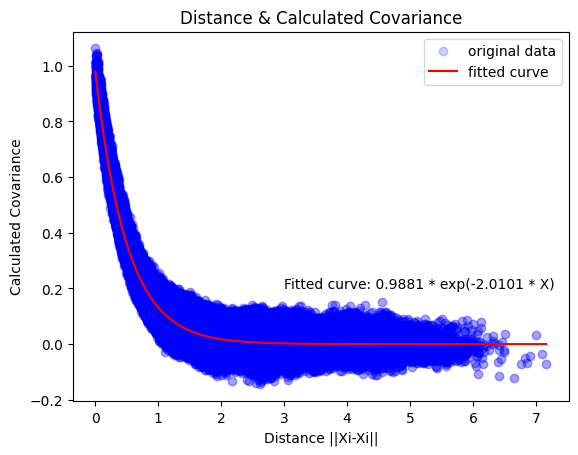

In [24]:
# exponential regression
plt.scatter(d_plot, cov_plot, c='blue', alpha=0.2, label='original data')
plt.plot(x_fit1, y_fit1, c='red', label='fitted curve')
plt.ylabel('Calculated Covariance')
plt.xlabel('Distance ||Xi-Xi||')

plt.title('Distance & Calculated Covariance')
plt.legend()
plt.text(3.0, 0.2, fit1)
# plt.xlim(0,0.2)
plt.show()

## 3-2. Try log transformation
* $ log(Cov(yi, yj|X)) = log(\theta_1) -\theta_2 X $

/Users/yeonsoo/Documents/Research/Covariance-Modeling/SARvenv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


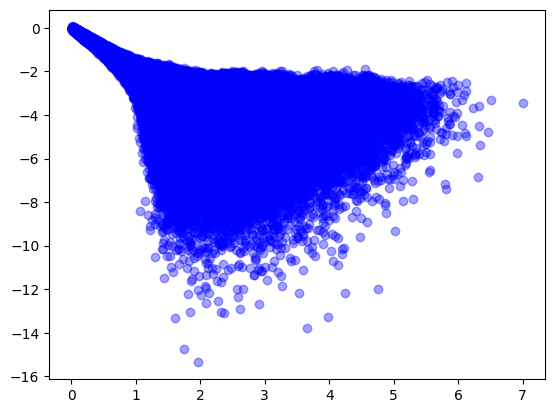

In [36]:
log_cov = np.log(cov_plot)

plt.scatter(d_plot, log_cov, color = 'b', alpha=0.2);

In [37]:
linregress(d_plot, log_cov)

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)

In [34]:
log_reg = linregress(d_plot, log_cov)
log_theta1, theta2 = log_reg.intercept, log_reg.slope
print("Linear regression result: log(Cov(y)) = {} - {}x".format(log_theta1, theta2))

Linear regression result: log(Cov(y)) = nan - nanx


In [ ]:
# linear regression
params, param_cov = curve_fit(logged_func, d_plot, log_plot)
theta1, theta2 = params

# generate fitted line
x_fit = np.linspace(min(d_plot), max(d_plot), 100)
y_fit = logged_func(x_fit, theta1, theta2)

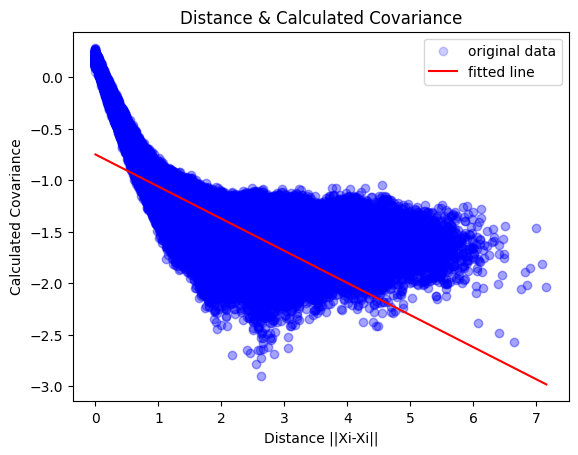

In [ ]:
# linear regression
plt.scatter(d_plot, log_plot, c='blue', alpha=0.2, label='original data')
plt.plot(x_fit, y_fit, c='red', label='fitted line')
plt.ylabel('Calculated Covariance')
plt.xlabel('Distance ||Xi-Xi||')

plt.title('Distance & Calculated Covariance')
plt.legend()
plt.show()

## 3-3. $E[y_i*y_j|X]$


In [65]:
# get combinations of yi*yj (i =/= j)
column_pairs = list(combinations(col_names, 2))

In [66]:
# distances referring to column_pairs
distances = pd.DataFrame(d, index=col_names, columns=col_names)
dis_pairs = [(distances[yi][yj]) for yi, yj in column_pairs]

In [67]:
# yi*yj pairs
y1 = y_df.loc[0,:]

product_pairs = []
index_names = []

for i in range(1, N):
    for j in range(i+1, N+1):
        product_pairs.append(y1['y{}'.format(i)]*y1['y{}'.format(j)])
        index_names.append('y{}*y{}'.format(i,j))

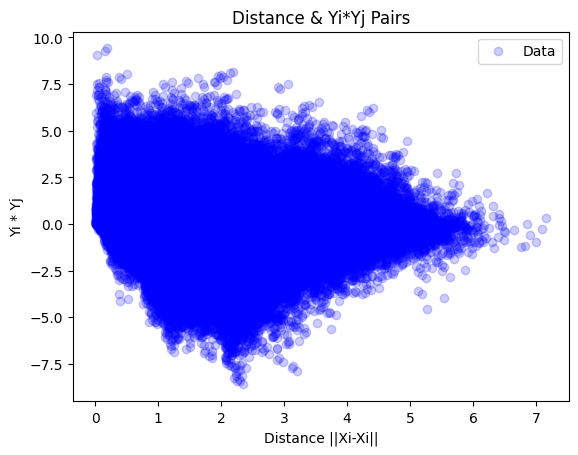

In [68]:
# plotting pairs data
plt.scatter(dis_pairs, product_pairs, color='blue', alpha=0.2, label='Data')
plt.xlabel('Distance ||Xi-Xi||')
plt.ylabel('Yi * Yj')
plt.title('Distance & Yi*Yj Pairs')
plt.legend()
plt.show()

In [69]:
# perform exponential regression
params, param_cov = curve_fit(exp_func, dis_pairs, product_pairs)

prod_theta1, prod_theta2 = params

x_fit2 = np.linspace(min(dis_pairs), max(dis_pairs), 100)
y_fit2 = exp_func(x_fit2, prod_theta1, prod_theta2)

fit2 = 'Fitted curve: {} * exp(-{} * X)'.format(round(prod_theta1,4), round(prod_theta2,4))
print(fit2)

Fitted curve: 1.5584 * exp(-2.0381 * X)


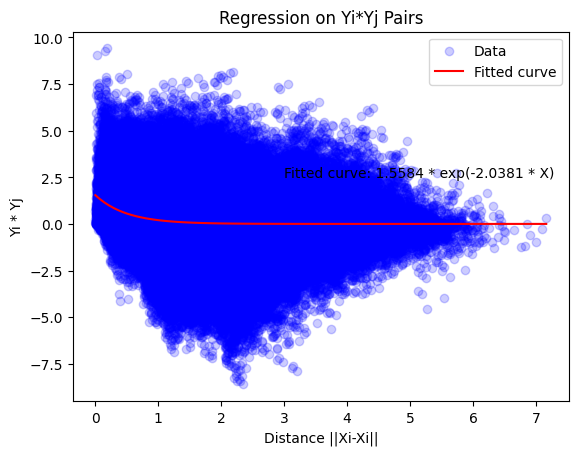

In [70]:
# plotting exponential regression of product pairs
plt.scatter(dis_pairs, product_pairs, color='blue', alpha=0.2, label='Data')
plt.plot(x_fit2, y_fit2, c='red', label='Fitted curve')
plt.xlabel('Distance ||Xi-Xi||')
plt.ylabel('Yi * Yj')
plt.title('Regression on Yi*Yj Pairs')
plt.text(3.0, 2.5, fit2)
plt.legend()
plt.show()

# 4. Scaling

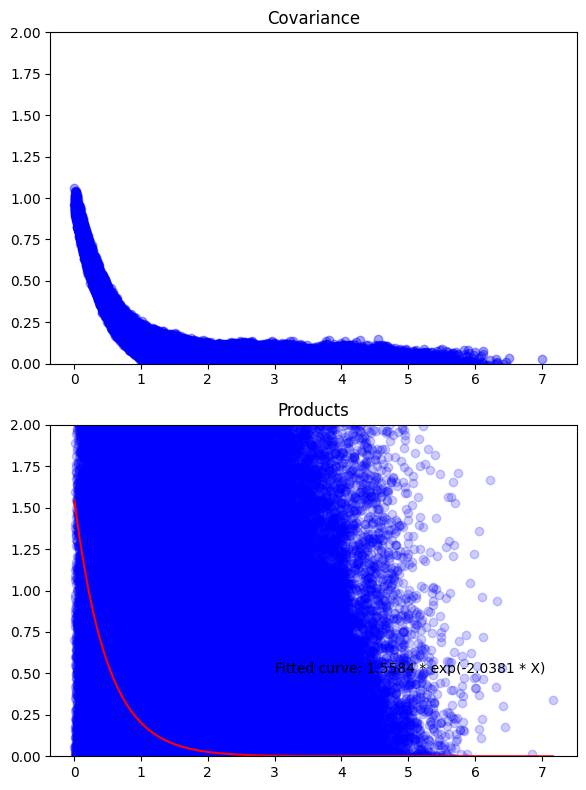

In [ ]:
# create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# plot the data in the first subplot
ax1.scatter(d_plot, cov_plot, c='blue', alpha=0.2)
ax1.set_title('Covariance')

# plot the data in the second subplot
ax2.scatter(dis_pairs, product_pairs, color='blue', alpha=0.2)
ax2.plot(x_fit2, y_fit2, c='red', label='Fitted curve')
ax2.text(3.0, 0.5, fit2)
ax2.set_title('Products')

# adjust the y-axis limits of both subplots to be the same
# min_y = min(np.min(cov_plot), np.min(product_pairs))
# max_y = max(np.max(cov_plot), np.max(product_pairs))
ax1.set_ylim(0, 2)
ax2.set_ylim(0, 2)

# display the plots
plt.tight_layout()
plt.show()

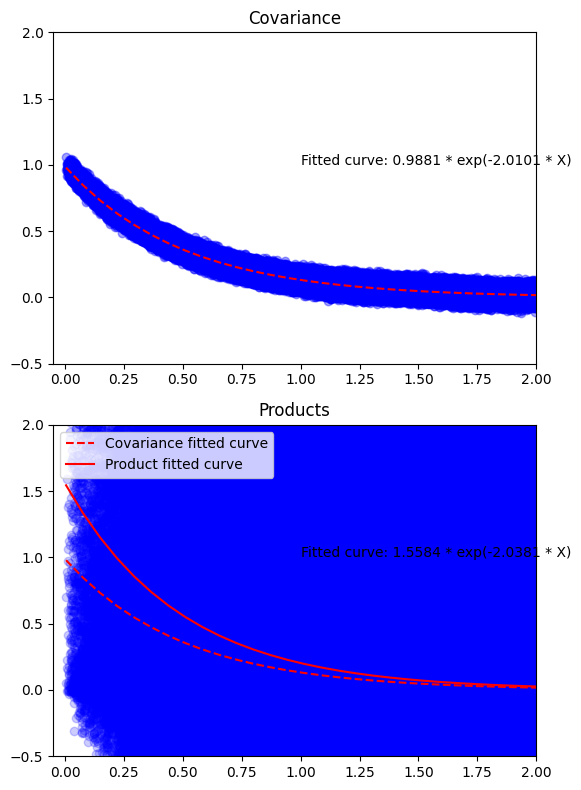

In [71]:
# create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# plot the data in the first subplot
ax1.scatter(d_plot, cov_plot, c='blue', alpha=0.2)
ax1.plot(x_fit1, y_fit1, c='red', linestyle='dashed', label='Fitted curve')
ax1.text(1.0, 1.0, fit1)
ax1.set_title('Covariance')

# plot the data in the second subplot
ax2.scatter(dis_pairs, product_pairs, color='blue', alpha=0.2)
ax2.plot(x_fit1, y_fit1, c='red', linestyle='dashed', label='Covariance fitted curve')
ax2.plot(x_fit2, y_fit2, c='red', label='Product fitted curve')
ax2.text(1.0, 1.0, fit2)
ax2.legend()
ax2.set_title('Products')

# adjust the y-axis limits of both subplots to be the same
# min_y = min(np.min(cov_plot), np.min(product_pairs))
# max_y = max(np.max(cov_plot), np.max(product_pairs))
ax1.set_ylim(-0.5, 2)
ax2.set_ylim(-0.5, 2)

ax1.set_xlim(-0.05, 2)
ax2.set_xlim(-0.05, 2)

# display the plots
plt.tight_layout()
plt.show()

# 4. Try ML Regression

In [165]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_union
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

## 4-0. Train / Test Split

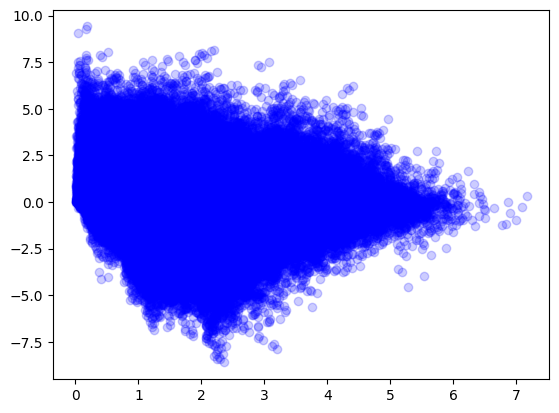

In [73]:
plt.scatter(dis_pairs, product_pairs, color='blue', alpha=0.2, label='Data');

In [77]:
# reshape into 2D array
X = np.array(dis_pairs)[:,np.newaxis]
y = np.array(product_pairs)[:,np.newaxis]

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

In [79]:
print(X_train.shape, X_test.shape)

(399600, 1) (99900, 1)


## 4-1. Ridge Regression

In [129]:
# create a function for exponential transformation
exp_transform = FunctionTransformer(func=exp_func, kw_args={'theta1': 1, 'theta2': 0.5})


In [185]:
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('exponential', exp_transform),
    ('model', Ridge(alpha=0.1))
])

In [186]:
pipeline_ridge.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('exponential',
                 FunctionTransformer(func=<function exp_func at 0x1414cbb00>,
                                     kw_args={'theta1': 1, 'theta2': 0.5})),
                ('model', Ridge(alpha=0.1))])

In [198]:
# retrieve the learned coefficients from the Ridge regression model
theta1_hat = pipeline_ridge.named_steps['model'].coef_[0]
theta2_hat = -np.log(theta1_hat)
ridge_fit = "y = {}*exp(-{}*x)".format(round(theta1_hat,4), round(theta2_hat,4))

print("Estimated function: " + ridge_fit)

Estimated function: y = 0.54*exp(-0.6161*x)


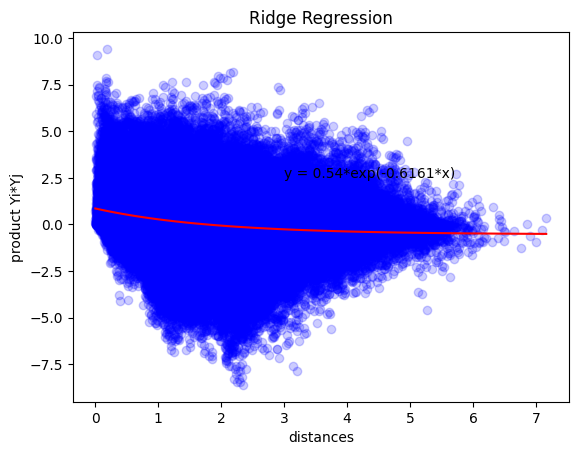

In [199]:
x_fit = np.linspace(min(X_train[:,0]), max(X_train[:,0]), 100)[:,np.newaxis]
y_hat = pipeline_ridge.predict(x_fit)

plt.scatter(X_train[:,0], y_train, alpha=0.2, c='b')
plt.plot(x_fit, y_hat,c='r')
plt.title('Ridge Regression')
plt.xlabel('distances')
plt.ylabel('product Yi*Yj')
plt.text(3, 2.5, ridge_fit);

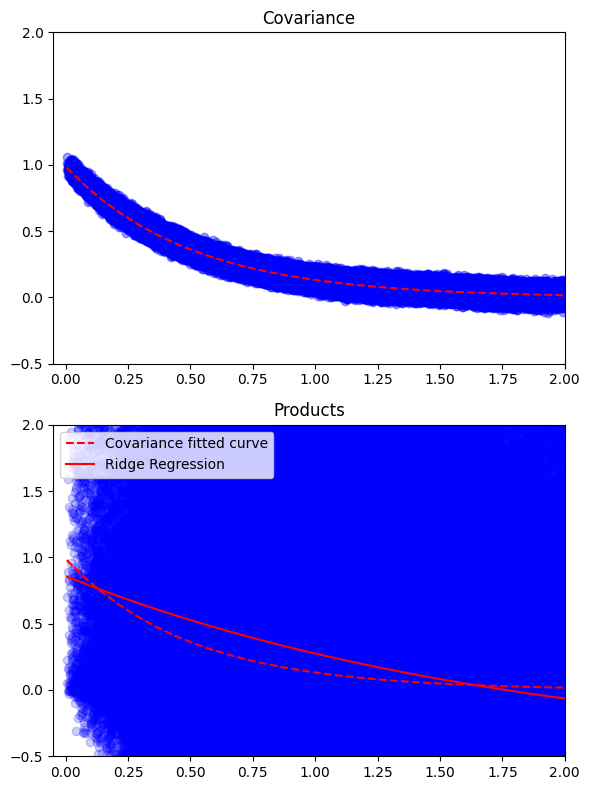

In [200]:
# create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# plot the data in the first subplot
ax1.scatter(d_plot, cov_plot, c='blue', alpha=0.2)
ax1.plot(x_fit1, y_fit1, c='red', linestyle='dashed', label='Fitted curve')
ax1.set_title('Covariance')

# plot the data in the second subplot
ax2.scatter(X_train[:,0], y_train, alpha=0.2, c='b')

ax2.plot(x_fit1, y_fit1, c='red', linestyle='dashed', label='Covariance fitted curve')
ax2.plot(x_fit, y_hat, c='red', label='Ridge Regression')
ax2.legend()
ax2.set_title('Products')

# adjust the y-axis limits of both subplots to be the same
# min_y = min(np.min(cov_plot), np.min(product_pairs))
# max_y = max(np.max(cov_plot), np.max(product_pairs))
ax1.set_ylim(-0.5, 2)
ax2.set_ylim(-0.5, 2)

ax1.set_xlim(-0.05, 2)
ax2.set_xlim(-0.05, 2)

# display the plots
plt.tight_layout()
plt.show()